# 多媒體作業

# 學號 F74056247 曾大瑋
使用python完成

建議使用jupyter-notebook觀看

# 讀入所需的library及檔案

In [1]:
import matplotlib.pyplot as plt
import scipy.fftpack as sf
from scipy.io import wavfile
import os
import numpy as np

In [2]:
files = os.listdir("./")
samplerate, data = wavfile.read("./sample.wav")
print("Sample rate at "+str(samplerate)+" Hz")
print("Have "+str(len(data))+" samples")

Sample rate at 8000 Hz
Have 27000 samples


# 音訊倍率調整

把音訊的範圍調整到+1.0~-1.0

並且畫出波型圖

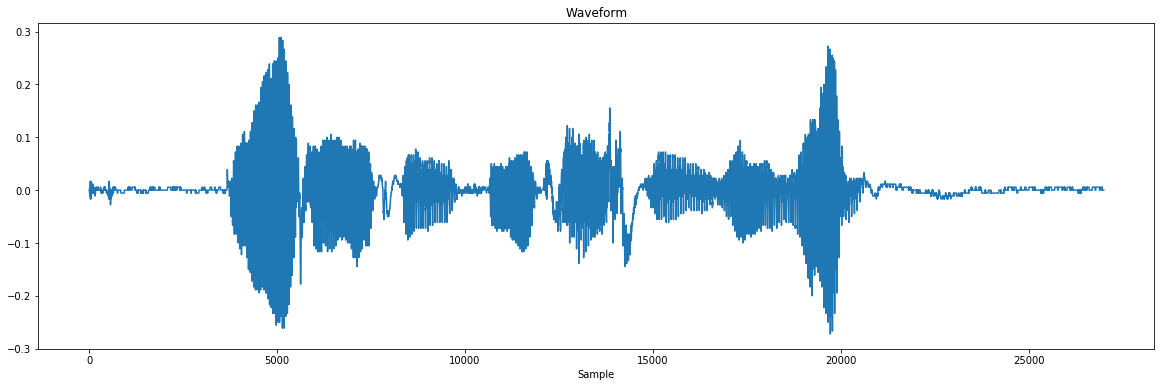

In [3]:
samples=[]
temp=[]
for item in range(len(data)):
    samples.append(data[item])

for item in range(len(samples)):
    temp.append(abs(samples[item]))

maxium=max(samples)

for item in range(len(samples)):
    samples[item] = samples[item]/maxium
    
temp=np.sum(samples)/len(samples)
for item in range(len(samples)):
    samples[item]-=temp

plt.figure(figsize=[20,6])
plt.plot(samples)
plt.title('Waveform')
plt.xlabel('Sample')
plt.show()

# 計算short Term energy

先計算出有幾個frame數

chunk則是儲存frame用,每chunk儲存160samples= 1 frame

再畫出short time energy

In [4]:
sampsPerMilli = int(samplerate / 1000)
msFrame = 20
samFrame = sampsPerMilli * msFrame

frameNumber = (len(samples)-len(samples)%samFrame) / samFrame
drop=len(samples)%samFrame

# drop last frame part to prevent overlap
if drop>0:
    samples=samples[:-1*drop]

print ('Have ' + str(sampsPerMilli) + ' samples per ms')
print ('Therefore '+ str(samFrame) + ' samples in 1 frame(1 frame= '+ str(msFrame) +' ms )')
print ('Have '+str(int(frameNumber)) + ' number of frames  ')

Have 8 samples per ms
Therefore 160 samples in 1 frame(1 frame= 20 ms )
Have 168 number of frames  


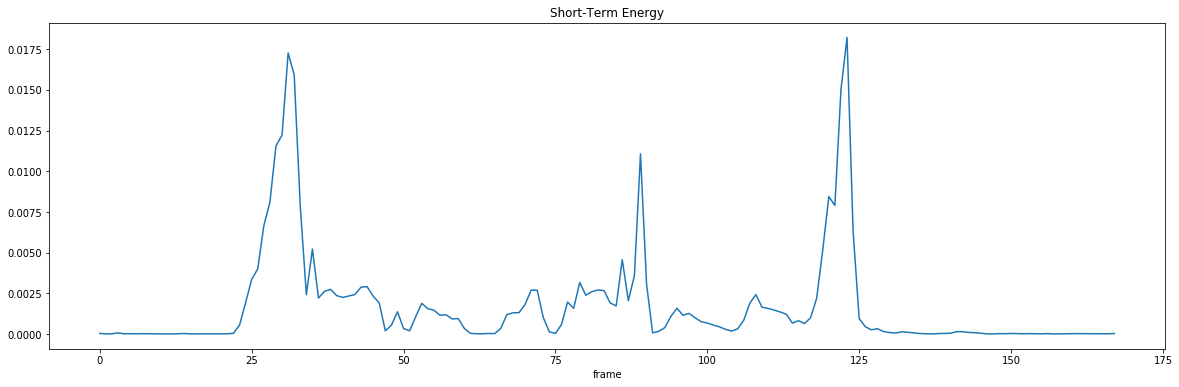

In [5]:
#function to split chunks
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
# calculat short term energy
def shortTermEnergy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

x=list(chunks(samples, 160))

STE = [] # list of short-time energies

for item in range(len(x)):
    STE.append(shortTermEnergy(x[item]))

plt.figure(figsize=[20,6])
plt.plot(STE)
plt.title('Short-Term Energy')
plt.xlabel('frame')
plt.show()

# 計算 Zero crossing rate

使用numpy 的np.sign取出當前frame內每個sample是正值或負值

總和出當前frame的zero crossing rate


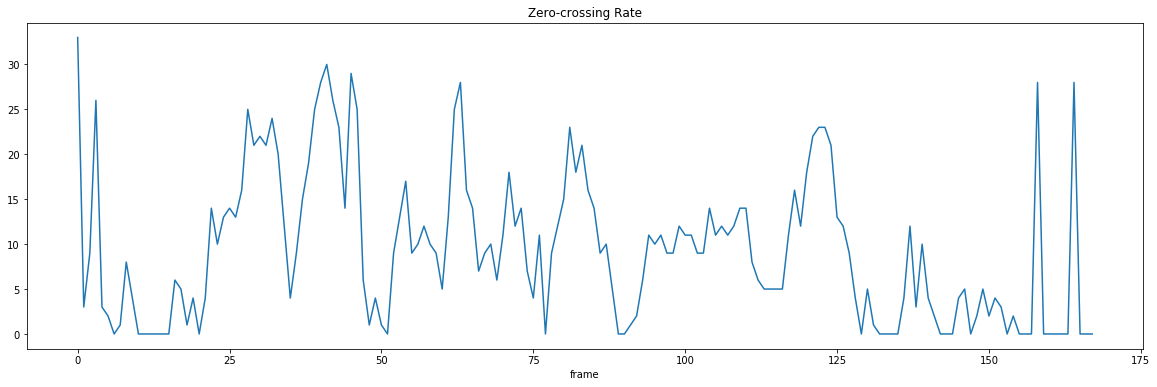

In [6]:
ZCCs=[]
def zeroCrossingCount(frame):
    ZCC=0
    for k in range(1, len(frame)):
            ZCC += 0.5 * abs(np.sign(frame[k]) - np.sign(frame[k - 1]))
    return ZCC


for item in range(len(x)):
    ZCCs.append(zeroCrossingCount(x[item]))


plt.figure(figsize=[20,6])
plt.plot(ZCCs)
plt.title('Zero-crossing Rate')
plt.xlabel('frame')
plt.show()

# 計算end point

先算出每個frame的volume

用當前音量的大小判定end point

取當前平均差0.1標準差當作是start point 及 end point

紅色線為start point 綠色為 end point

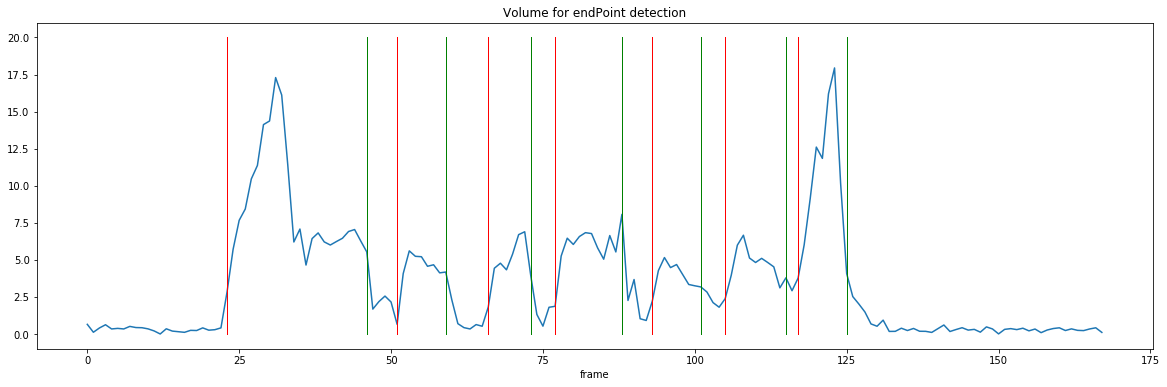

In [7]:
volume=[]
def calculateVolume(frame):
    result=frame-np.median(frame)
    return np.sum(np.abs(result))

for item in range(len(x)):
    volume.append(calculateVolume(x[item]))

startXposList=[]
endXposList=[]
isStart=False
avgVol=sum(volume)/len(volume)
stdVol=np.std(volume)

for item in range(len(volume)-1):
    if volume[item+1]>avgVol+stdVol*0.1 and isStart==False:
        isStart=True
        startXposList.append((item))

    if volume[item+1]<avgVol-stdVol*0.1 and isStart==True:
        isStart=False
        endXposList.append((item))

        
    
plt.figure(figsize=[20,6])
plt.title('Volume for endPoint detection')
plt.xlabel('frame')
plt.plot(volume)

for item in range(len(startXposList)):
    #print(startXposList[item])
    plt.plot([startXposList[item],startXposList[item]],[0,20],'r', lw=1)
    
for item in range(len(endXposList)):
    #print(endXposList[item])
    plt.plot([endXposList[item],endXposList[item]],[0,20],'g', lw=1)


# Pitch 

對每個frame 做fourier transform 取得 Spectrum

取出其中最大值作為此frame的pitch

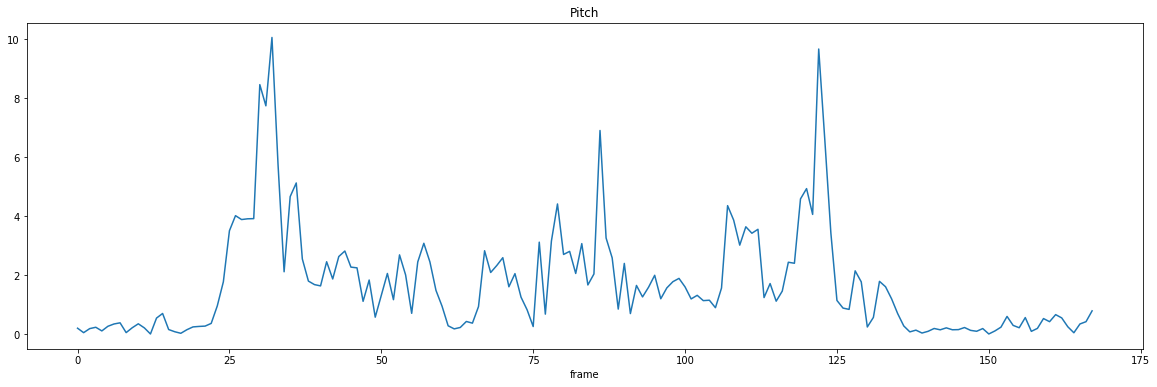

In [8]:
voiceVector = []
y=np.array(x)

# low pass and high pass filter
Low_cutoff=80
High_cutoff= 300

F_sample=20

for window in range(len(y)):

    temp=np.array(y[window])
    M = temp.size
    Spectrum = sf.rfft(temp, n=M) 
    [Low_cutoff, High_cutoff, F_sample] = map(float, [Low_cutoff, High_cutoff, F_sample])
    #Convert cutoff frequencies into points on spectrum
    [Low_point, High_point]= map(lambda F: F//F_sample * M, [Low_cutoff, High_cutoff])
    voiceVector.append(max(Spectrum))

plt.figure(figsize=[20,6])
plt.plot(voiceVector)
plt.title('Pitch')
plt.xlabel('frame')
plt.show()

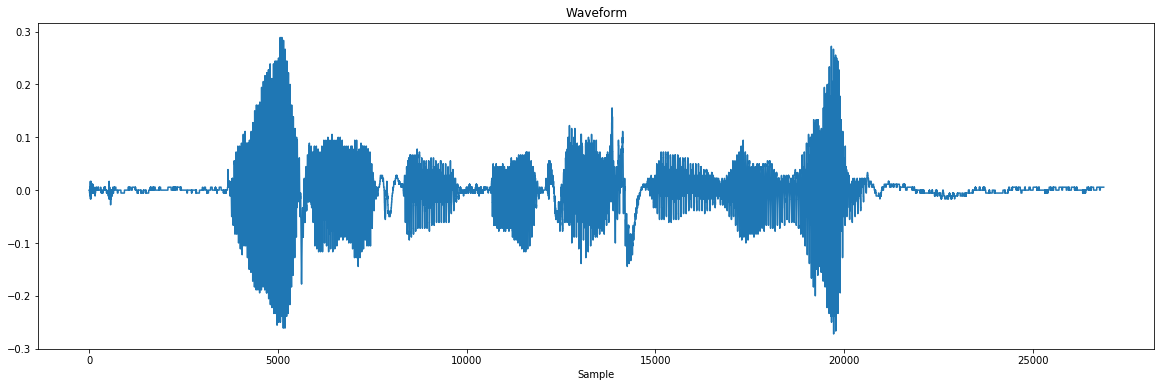

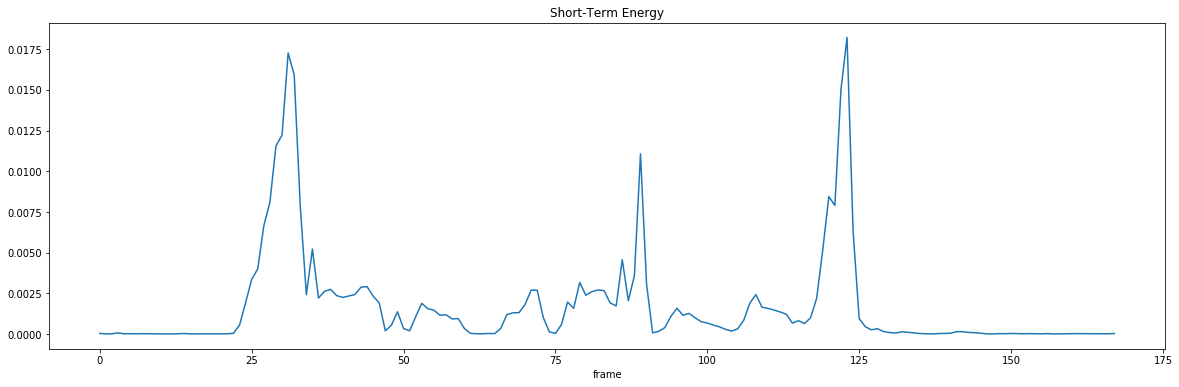

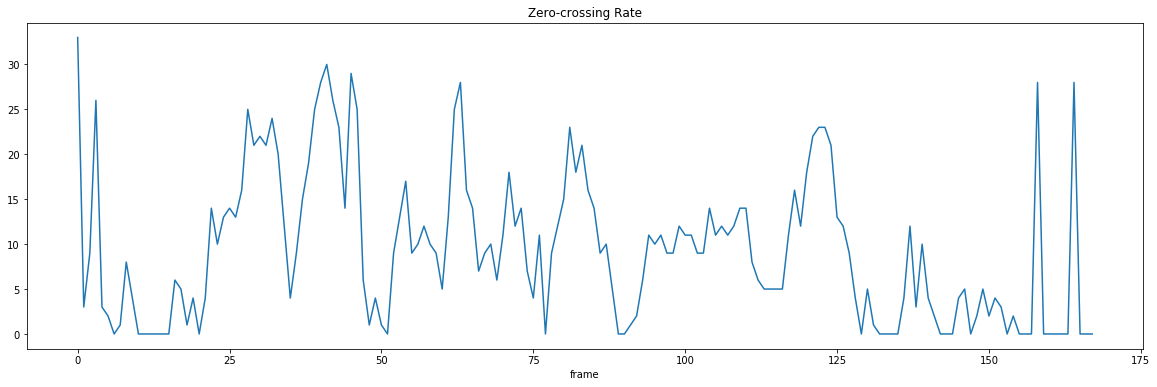

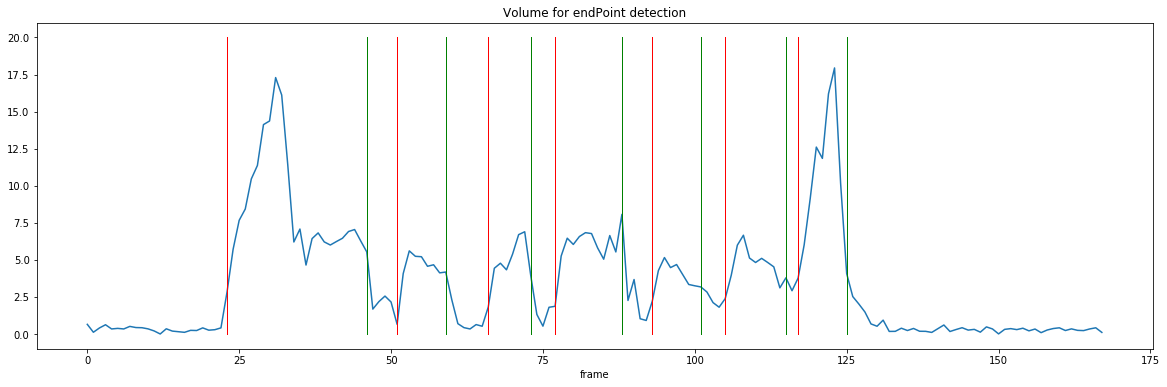

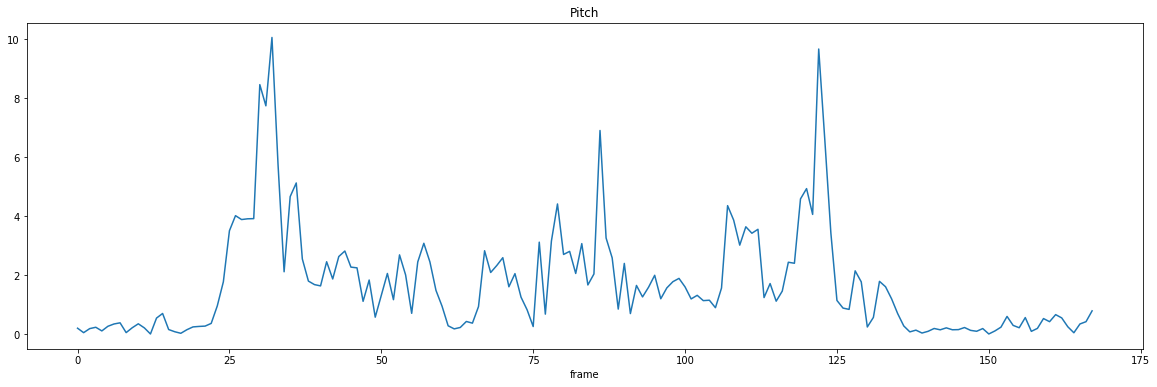

In [9]:
plt.figure(figsize=[20,6])
plt.plot(samples)
plt.title('Waveform')
plt.xlabel('Sample')
plt.show()

plt.figure(figsize=[20,6])
plt.plot(STE)
plt.title('Short-Term Energy')
plt.xlabel('frame')
plt.show()

plt.figure(figsize=[20,6])
plt.plot(ZCCs)
plt.title('Zero-crossing Rate')
plt.xlabel('frame')
plt.show()

plt.figure(figsize=[20,6])
plt.title('Volume for endPoint detection')
plt.xlabel('frame')
plt.plot(volume)

for item in range(len(startXposList)):
    #print(startXposList[item])
    plt.plot([startXposList[item],startXposList[item]],[0,20],'r', lw=1)
    
for item in range(len(endXposList)):
    #print(endXposList[item])
    plt.plot([endXposList[item],endXposList[item]],[0,20],'g', lw=1)
    
plt.figure(figsize=[20,6])
plt.plot(voiceVector)
plt.title('Pitch')
plt.xlabel('frame')
plt.show()